In [1]:
import os
import sys
import json
import yaml
import numpy as np
import pandas as pd
import copy
import math
from einops import rearrange
from einops.layers.torch import Rearrange
import time
import random
import h5py
import webdataset as wds
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import utils
import models
from accelerate import Accelerator, load_checkpoint_in_model

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print("NUM GPUS ", num_devices)

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    %load_ext autoreload
    %autoreload 2
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

LOCAL RANK  0
NUM GPUS  1


In [2]:
# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

# create global variables from the config
for attribute_name in config.keys():
    globals()[attribute_name] = config[f'{attribute_name}']

# First use "accelerate config" in terminal for setup
data_type = torch.float16 # change depending on your mixed_precision
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
batch_size = global_batch_size // num_devices

/weka/home-alexnguyen/mamba_fmri/fmri/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=False)
  warnings.warn(


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:", device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 734850
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configuration

In [4]:
print(config)

# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../ckpts/{model_name}')
print("outdir", outdir)

cache_dir = cache_dir + f'/{np.random.randint(9999)}' # create random subfolder so multiple runs arent using same directory
os.makedirs(cache_dir,exist_ok=True)
print("cache_dir", cache_dir)

if use_contrastive_loss:
    global_batch_size = global_batch_size // 2 # contrastive loss doubles the batch size with the same samples and different masks
print("global_batch_size", global_batch_size)

use_cls_token = True if use_contrastive_loss else use_cls_token
print("use_cls_token", use_cls_token)

num_patches = int(
    (img_size[0] / patch_size)
    * (img_size[1] / patch_size)
    * (img_size[2] / patch_size)
    * num_frames
)
num_patches_per_timepoint = num_patches // num_frames
num_encoder_patches = int(num_patches_per_timepoint * (1 - tube_start_masking_ratio) * num_frames)
num_decoder_patches = int(num_patches_per_timepoint * (1 - decoder_mask_ratio) * num_frames)
print("num_patches", num_patches)
print("num_encoder_patches", num_encoder_patches)
print("num_decoder_patches", num_decoder_patches)

{'model_name': 'patch8_100eps_4gpu_accelerate_b', 'use_cls_token': False, 'use_contrastive_loss': False, 'constrastive_loss_weight': 1.0, 'global_batch_size': 8, 'num_workers': 4, 'num_epochs': 100, 'seed': 42, 'max_lr': 3e-05, 'num_samples_per_epoch': 1024, 'cache_dir': 'cache', 'ckpt_saving': True, 'ckpt_interval': 50, 'resume_from_ckpt': False, 'wandb_log': True, 'tube_start_masking_ratio': 0.75, 'tube_end_masking_ratio': 0.75, 'decoder_mask_ratio': 0.75, 'encoder_model': 'vit_base', 'decoder_model': 'vit_small', 'patch_size': 8, 'frame_patch_size': 1, 'use_rope_emb': False, 'img_size': [64, 64, 48], 'num_frames': 4, 'train_urls': 's3://proj-fmri/fmri_foundation_datasets/openneuro/{000005..000664}.tar', 'test_urls': 's3://proj-fmri/fmri_foundation_datasets/openneuro/{000000..000004}.tar'}
outdir /weka/home-alexnguyen/mamba_fmri/ckpts/patch8_100eps_4gpu_accelerate_b
cache_dir cache/7270
global_batch_size 8
use_cls_token False
num_patches 1536
num_encoder_patches 384
num_decoder_patch

# Prep models

In [5]:

vit_size = {
    "encoder": encoder_model,
    "decoder": decoder_model
}
    
vit_model = models.get_vit(
    size=vit_size,
    image_size=img_size,  # depth, height, width
    image_patch_size=(patch_size,patch_size,patch_size),  # depth, height, width patch size
    frames=num_frames,
    frame_patch_size=frame_patch_size,
    channels=1,
    use_rope_emb=use_rope_emb,
    use_cls_token=use_cls_token,
)
model = models.get_mamba("middle",
                        channels=1,
                        img_size=img_size,  # depth, height, width
                        patch_size=(patch_size,patch_size,patch_size),
                        num_frames=num_frames,
                        frame_patch_size=frame_patch_size
                        )

utils.count_params(model)

# test that the model works without error
model = model.to(device)
# encoder_mask = torch.zeros(num_patches).to(device).to(torch.bool)
# encoder_mask[:num_encoder_patches] = True
# decoder_mask = torch.zeros(num_patches).to(device).to(torch.bool)
# decoder_mask[-num_decoder_patches:] = True
# with torch.no_grad():
#     print("\nencoder")
#     encoder_out = model(
#                 torch.randn(6, 1, 4, 64, 64, 48).to(device),
#                 mask=encoder_mask)
#     print("\ndecoder")
#     decoder_out = model(
#                 encoder_out, 
#                 encoder_mask=encoder_mask, 
#                 decoder_mask=decoder_mask)
#     if use_cls_token:
#         enc_cls_token = encoder_out[:, :1, :]
#         encoder_patches = encoder_out[:, 1:, :]
#         dec_cls_token = decoder_out[:, :1, :]
#         decoder_patches = decoder_out[:, 1:, :]
#         print("\nenc_cls_token", enc_cls_token.shape)
#         print("encoder_patches", encoder_patches.shape)
#         print("dec_cls_token", dec_cls_token.shape)
#         print("decoder_patches", decoder_patches.shape)

Use checkpoint: False
Checkpoint number: 0
Student return index: [31]
depth 32 d_model 512 rms_norm True residual_in_fp32 True fused_add_norm True bimamba True ssm_cfg None
Normalization Type: l2
param counts:
58,710,016 total
58,710,016 trainable


In [6]:
aug_transform = utils.DataPrepper(
    masking_strategy="conservative",
    patch_depth=patch_size,
    patch_height=patch_size,
    patch_width=patch_size,
    frame_patch_size=frame_patch_size,
)

def log_and_continue(exn):
    """Call in an exception handler to ignore any exception, issue a warning, and continue."""
    print(f'Handling webdataset error ({repr(exn)}). Ignoring.')
    return True

def filter_corrupted_images(sample):
    """If all the required files are not present don't use them."""
    correct_data = ("func.png" in sample and "dataset.txt" in sample and "header.npy" in sample and "meansd.png" in sample and "minmax.npy" in sample)
    return correct_data

### ================      Train Dataset and DataLoader    ====================
if train_urls[:2] == "s3":
    train_urls = f"pipe:aws s3 cp {train_urls} -"
print(train_urls)
train_data = (
    wds.WebDataset(train_urls, resampled=True, nodesplitter=utils.my_split_by_node, cache_dir=cache_dir, handler=log_and_continue)
    .shuffle(100, initial=100, rng=random.Random(seed))
    .select(filter_corrupted_images)
    .rename(key="__key__",
        func="func.png",
        header="header.npy",
        dataset="dataset.txt",
        minmax="minmax.npy",
        meansd="meansd.png")
    .map_dict(func=utils.grayscale_decoder,
        meansd=utils.grayscale_decoder,
        minmax=utils.numpy_decoder)
    .to_tuple(*("func", "minmax", "meansd"))
    .map(aug_transform)
    .with_epoch(num_samples_per_epoch)
)
train_dl = wds.WebLoader(
    train_data.batched(batch_size), 
    pin_memory=True,
    shuffle=False,
    batch_size=None,
    num_workers=num_workers, 
    persistent_workers=num_workers>0,
).with_epoch(num_samples_per_epoch//batch_size)

### ================      Test Dataset and DataLoader    ====================
if test_urls[:2] == "s3":
    test_urls = f"pipe:aws s3 cp {test_urls} -"
print(test_urls)
test_data = (
    wds.WebDataset(test_urls, resampled=False, nodesplitter=utils.my_split_by_node, cache_dir=cache_dir, handler=log_and_continue)
    .select(filter_corrupted_images)
    .rename(key="__key__",
        func="func.png",
        header="header.npy",
        dataset="dataset.txt",
        minmax="minmax.npy",
        meansd="meansd.png")
    .map_dict(func=utils.grayscale_decoder,
        meansd=utils.grayscale_decoder,
        minmax=utils.numpy_decoder)
    .to_tuple(*("func", "minmax", "meansd"))
    .map(aug_transform)
)
test_dl = wds.WebLoader(
    test_data.batched(batch_size), 
    pin_memory=True,
    shuffle=False,
    batch_size=None,
    num_workers=num_workers,
    persistent_workers=num_workers>0,
)

pipe:aws s3 cp s3://proj-fmri/fmri_foundation_datasets/openneuro/{000005..000664}.tar -
pipe:aws s3 cp s3://proj-fmri/fmri_foundation_datasets/openneuro/{000000..000004}.tar -


In [7]:
from accelerate.state import AcceleratorState
try:
    AcceleratorState().deepspeed_plugin.deepspeed_config['train_micro_batch_size_per_gpu'] = global_batch_size
    print("deepspeed reconfigured, train_micro_batch_size_per_gpu = ", global_batch_size)
except:
    print("skipping deepspeed reconfiguration...")

skipping deepspeed reconfiguration...


### Check data loaders work and calculate number of iterations per epoch

In [8]:
num_iterations_per_epoch = num_samples_per_epoch // batch_size
print(f"num_iterations_per_epoch {num_iterations_per_epoch}")

train_batch = next(iter(train_dl))
func, meansd, brain_pos_pats = train_batch
print("Train batch:", func.shape, meansd.shape, brain_pos_pats.shape)

for test_num_iterations_per_epoch, test_batch in enumerate(test_dl):
    pass
print(f"test_num_iterations_per_epoch {test_num_iterations_per_epoch}")
func, meansd, brain_pos_pats = test_batch
print("Test batch:", func.shape, meansd.shape, brain_pos_pats.shape)

num_iterations_per_epoch 128
Train batch: torch.Size([8, 4, 64, 64, 48]) torch.Size([8, 2, 64, 64, 48]) torch.Size([8, 1536])
test_num_iterations_per_epoch 199
Test batch: torch.Size([8, 4, 64, 64, 48]) torch.Size([8, 2, 64, 64, 48]) torch.Size([8, 1536])


# Playing with the data, visualization of patching + masking

func torch.Size([8, 1, 4, 64, 64, 48])
patches torch.Size([8, 4, 8, 8, 6, 512])
patches_vit torch.Size([8, 1536, 512])
num patches in one timepoint 384
Percentage of brain positive patches 1.0 mask_idx_candidates.shape torch.Size([384])
num tube patches = 96
tube mask percent 0.25 torch.Size([1536])
num decoder patches = 96
decoder_mask percent 0.25
tube_unpatches torch.Size([8, 4, 8, 8, 6, 512])
decoder_unpatches torch.Size([8, 4, 8, 8, 6, 512])
tube_func torch.Size([8, 1, 4, 64, 64, 48])
decoder_func torch.Size([8, 1, 4, 64, 64, 48])
original func without adding mean/sd references


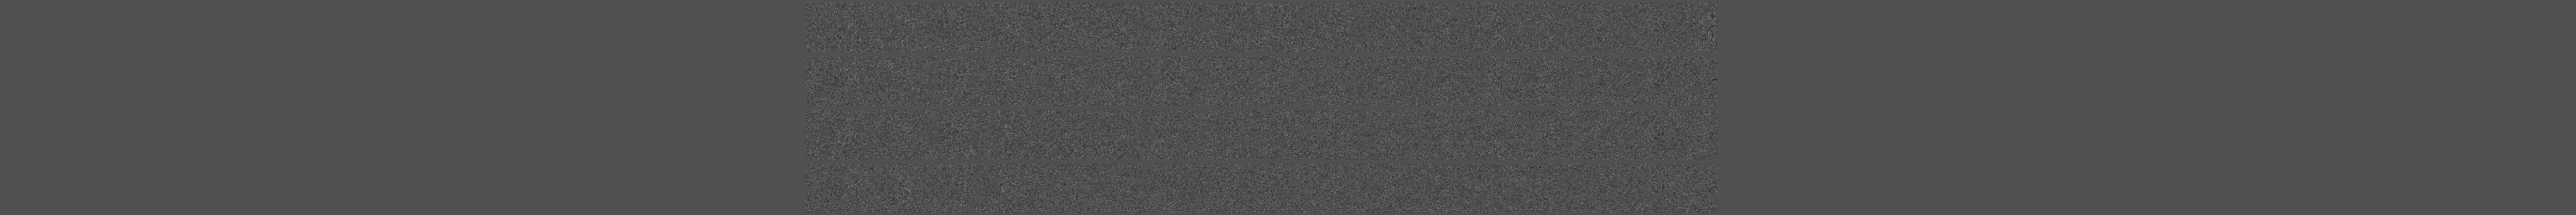

original func


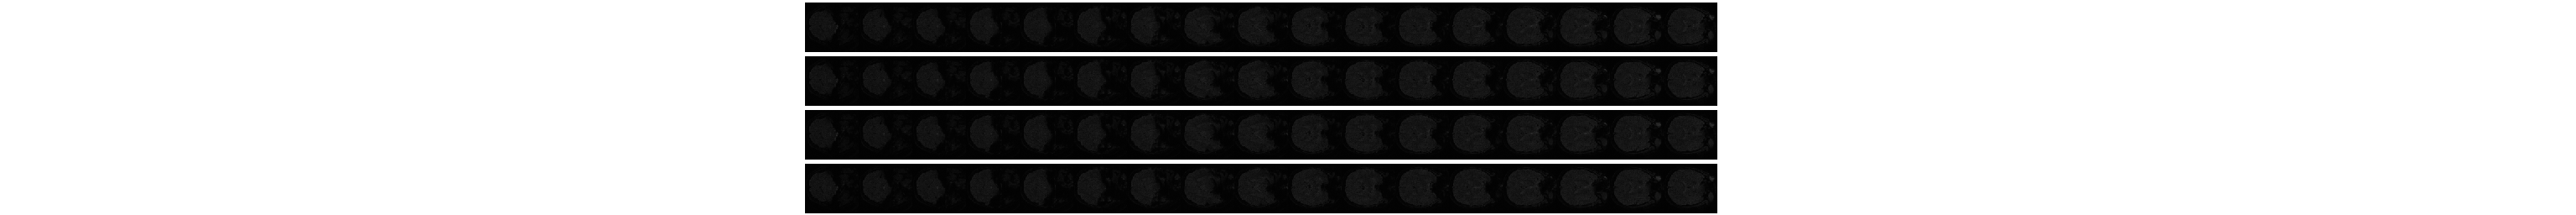


brain-positive patches


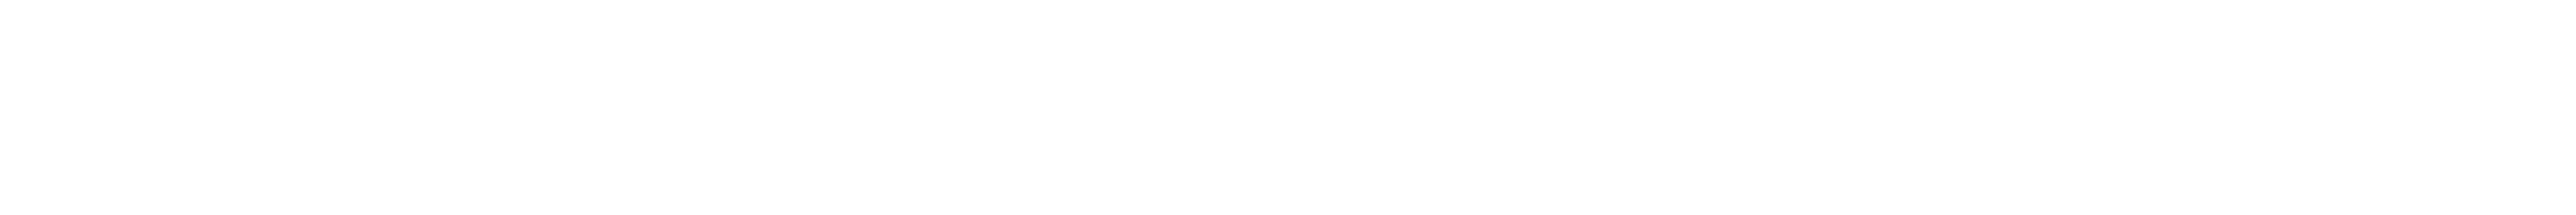


tube func without adding mean/sd references


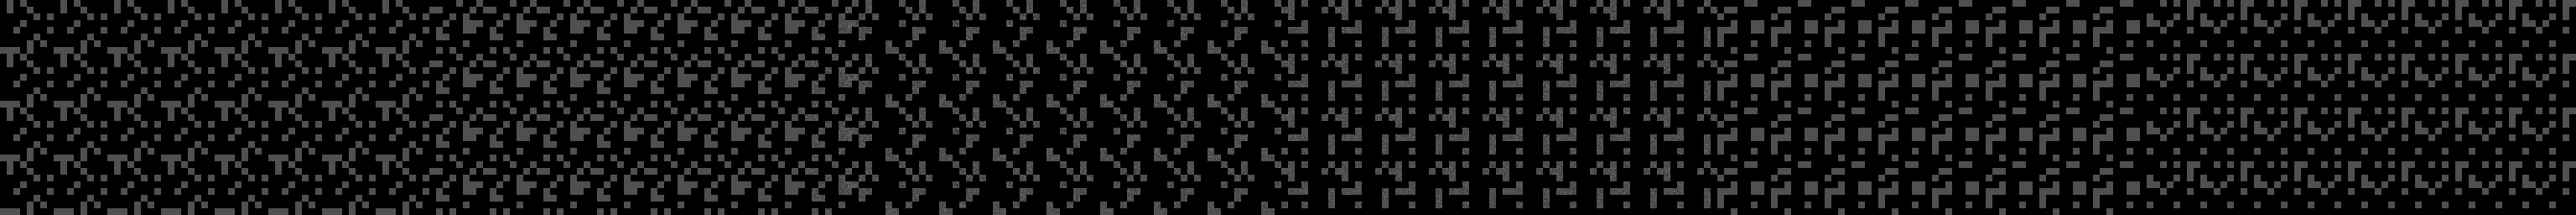

tube func


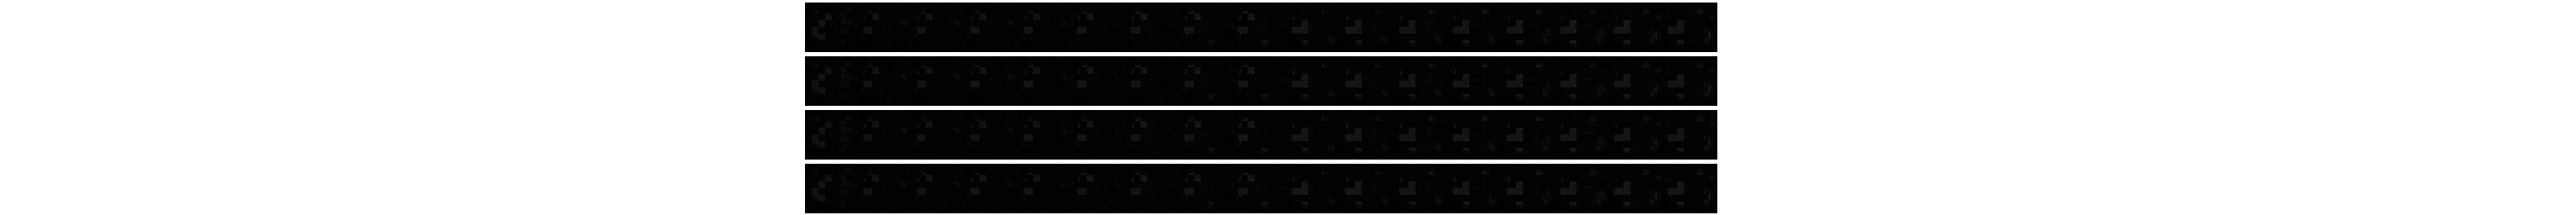


decoder func without adding mean/sd references


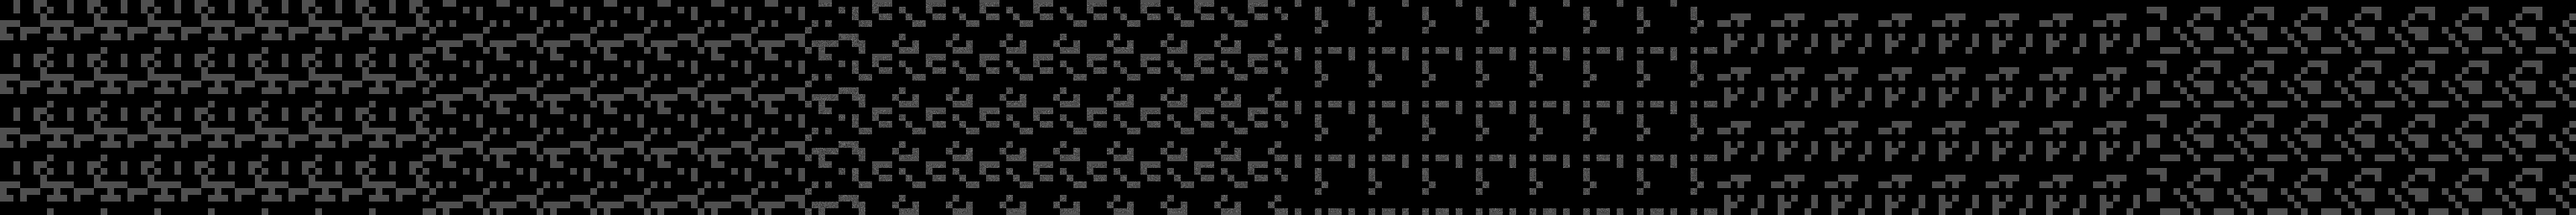

decoder func


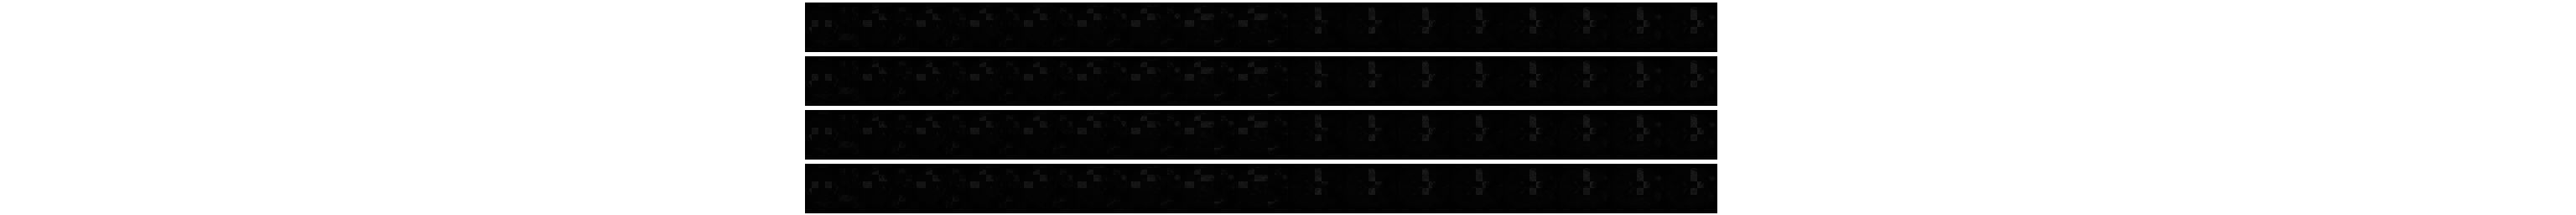

In [9]:
if utils.is_interactive():
    # extract func volumes and their reference mean and standard deviation volumes
    func, meansd, brain_pos_pats = train_batch
    func = func.unsqueeze(1)  # add empty first dimension to serve as 1d channel dimension

    # patchify func samples
    print("func", func.shape)
    patches = model.patchify(func)
    print("patches", patches.shape)
    patches_vit = rearrange(patches, "b ... d -> b (...) d")
    print("patches_vit", patches_vit.shape)
    print("num patches in one timepoint", patches_vit.shape[1] // num_frames)

    # start by masking everything (aka include nothing)
    tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
    # approximate brain positive patches for the whole batch
    batch_positive_approx = brain_pos_pats[:, :num_patches//num_frames].float().mean(dim=0) > 0
    mask_idx_candidates = torch.where(batch_positive_approx)[0]
    mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
    print("Percentage of brain positive patches",
        len(mask_idx_candidates) / len(batch_positive_approx), "mask_idx_candidates.shape", mask_idx_candidates.shape)
    tube_idx = mask_idx_candidates[: int(num_patches / num_frames * (1 - tube_start_masking_ratio))]
    print("num tube patches =", len(tube_idx))
    tube_mask[tube_idx] = True  # Trues mean to include the patch, False means to remove the patch
    tube_mask = tube_mask.tile(num_frames)  # repeat masking for the other timepoints
    print("tube mask percent", tube_mask.sum().item() / len(tube_mask), tube_mask.shape)

    # create decoder mask similar to tube mask, but ensure no overlap
    decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)  # start by masking everything (aka include nothing)
    remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_start_masking_ratio)) :]  # brain positive tokens not selected for the encoder tokens
    decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
    print("num decoder patches =", len(decoder_mask_idx))
    decoder_mask[decoder_mask_idx] = True
    decoder_mask = decoder_mask.tile(num_frames)  # repeat masking for the other timepoints
    print("decoder_mask percent", decoder_mask.sum().item() / len(decoder_mask))

    # apply masks to patches_vit
    tube_patches_vit = copy.deepcopy(patches_vit.detach())
    decoder_patches_vit = copy.deepcopy(patches_vit.detach())
    tube_patches_vit[:, ~tube_mask] = 0.0
    decoder_patches_vit[:, ~decoder_mask] = 0.0

    # undo patchification so we can visualize
    tube_unpatches = rearrange(
        tube_patches_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    decoder_unpatches = rearrange(
        decoder_patches_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    print("tube_unpatches", tube_unpatches.shape)
    print("decoder_unpatches", decoder_unpatches.shape)
    
    tube_func = rearrange(
        tube_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )
    decoder_func = rearrange(
        decoder_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )
    print("tube_func", tube_func.shape)
    print("decoder_func", decoder_func.shape)
    
    brain_pos_vit = copy.deepcopy(patches_vit.detach())
    brain_pos_vit[:,batch_positive_approx.repeat(num_frames)] = 1
    brain_pos_vit[:,~batch_positive_approx.repeat(num_frames)] = 0
    brain_pos_unpatches = rearrange(
        brain_pos_vit,
        "b (f d h w) c -> b f d h w c",
        d=img_size[0]//patch_size,
        h=img_size[1]//patch_size,
        w=img_size[2]//patch_size,
    )
    brain_pos_func = rearrange(
        brain_pos_unpatches,
        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
        b=len(func),
        f=num_frames,
        d=img_size[0] // patch_size,
        h=img_size[1] // patch_size,
        w=img_size[2] // patch_size,
        pd=patch_size,
        ph=patch_size,
        pw=patch_size,
        pf=frame_patch_size,
    )

    # Visualize
    idx = 0
    mean, sd = meansd[idx]
    print("original func without adding mean/sd references")
    display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx])))
    print("original func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx] * mean + sd)))
    
    print("\nbrain-positive patches")
    display(transforms.ToPILImage()(utils.reshape_to_2d(brain_pos_func[idx])))

    print("\ntube func without adding mean/sd references")
    display(transforms.ToPILImage()(utils.reshape_to_2d(tube_func[idx])))
    print("tube func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(tube_func[idx] * mean + sd)))

    print("\ndecoder func without adding mean/sd references")
    display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx])))
    print("decoder func")
    display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx] * mean + sd)))

# Set up optimizer and saving functions

In [10]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

total_steps = num_epochs * num_iterations_per_epoch * num_devices
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
)

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 12800

Done with model preparations!
param counts:
58,710,016 total
58,710,016 trainable


In [11]:
def save_ckpt(tag="last"):
    ckpt_path = outdir+f'/{tag}'
    os.makedirs(ckpt_path,exist_ok=True)
    accelerator.save_model(model, ckpt_path, max_shard_size="2GB", safe_serialization=True)
    print(f"\n---saved {ckpt_path}!---\n")
        
def save_progress(tag="last"):
    if accelerator.is_main_process:
        ckpt_path = outdir+f'/{tag}'
        torch.save(
                {
                    "optimizer": optimizer.state_dict(),
                    "scheduler": lr_scheduler.state_dict(),
                    "epoch": epoch,
                    "recon_losses": recon_losses,
                    "contrastive_losses": contrastive_losses,
                    "test_losses": test_losses,
                    "lrs": lrs,
                },
                os.path.join(ckpt_path, f"params.pt"),
            )

# Start wandb (if enabled)

In [ ]:
if accelerator.is_main_process and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'found'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_samples_per_epoch": num_samples_per_epoch,
      "encoder_model": encoder_model,
      "decoder_model": decoder_model,
      "tube_start_masking_ratio": tube_start_masking_ratio,
      "tube_end_masking_ratio": tube_end_masking_ratio,
      "decoder_mask_ratio": decoder_mask_ratio,
      "num_frames": num_frames,
      "patch_size": patch_size,
      "frame_patch_size": frame_patch_size,
      "use_contrastive_loss": use_contrastive_loss,
      "use_cls_token": use_cls_token,
      "constrastive_loss_weight": constrastive_loss_weight,
      "num_params": num_params,
      "max_lr": max_lr,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_urls": train_urls,
      "test_urls": test_urls,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        # id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
        group=wandb_group_name
    )
else:
    wandb_log = False

# Start training

In [12]:
epoch = 0
lrs, recon_losses, contrastive_losses, test_losses = [], [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [13]:
# resume from ckpt (e.g., if you are resuming from a run that got pre-empted)
load_progress = False
if wandb_log:
    if wandb.run.resumed:
        load_checkpoint_in_model(model, outdir+"/last")
        load_progress = True
elif resume_from_ckpt: # if resuming without using wandb
    load_checkpoint_in_model(model, outdir+"/last")
    load_progress = True
    
if load_progress:
    ckpt_path = outdir+'/last'
    prev_params = torch.load(ckpt_path+"/params.pt")
    optimizer.load_state_dict(prev_params["optimizer"])
    lr_scheduler.load_state_dict(prev_params["scheduler"])
    epoch = prev_params["epoch"]
    recon_losses = prev_params["recon_losses"]
    contrastive_losses = prev_params["contrastive_losses"]
    test_losses = prev_params["test_losses"]
    lrs = prev_params["lrs"]
    print("Loaded model params from", ckpt_path, "at epoch", epoch)

NameError: name 'wandb' is not defined

In [13]:
# import importlib
# importlib.reload(models)
# model = models.get_mamba("middle",
#                         channels=1,
#                         img_size=img_size,  # depth, height, width
#                         patch_size=(patch_size,patch_size,patch_size),
#                         num_frames=num_frames,
#                         frame_patch_size=frame_patch_size,
#                          clip_norm_type="none",
                         
#                         )

# vit_model = models.get_vit(
#     size=vit_size,
#     image_size=img_size,  # depth, height, width
#     image_patch_size=(patch_size,patch_size,patch_size),  # depth, height, width patch size
#     frames=num_frames,
#     frame_patch_size=frame_patch_size,
#     channels=1,
#     use_rope_emb=use_rope_emb,
#     use_cls_token=use_cls_token,
# )
# # train_urls
# # train_data = (
# #     wds.WebDataset(train_urls, resampled=True, nodesplitter=utils.my_split_by_node, cache_dir=cache_dir, handler=log_and_continue)
# #     .shuffle(100, initial=100, rng=random.Random(seed))
# #     .select(filter_corrupted_images)
# #     .rename(key="__key__",
# #         func="func.png",
# #         header="header.npy",
# #         dataset="dataset.txt",
# #         minmax="minmax.npy",
# #         meansd="meansd.png")
# #     .map_dict(func=utils.grayscale_decoder,
# #         meansd=utils.grayscale_decoder,
# #         minmax=utils.numpy_decoder)
# #     .to_tuple(*("func", "minmax", "meansd"))
# #     .map(aug_transform)
# #     .with_epoch(num_samples_per_epoch)
# # )
# # train_dl = wds.WebLoader(
# #     train_data.batched(batch_size), 
# #     pin_memory=True,
# #     shuffle=False,
# #     batch_size=None,
# #     num_workers=num_workers, 
# #     persistent_workers=num_workers>0,
# # ).with_epoch(num_samples_per_epoch//batch_size)

# model, train_dl = accelerator.prepare(
#     model, train_dl
# )
# vit_model = accelerator.prepare(
#     vit_model 
# )
# mse = nn.MSELoss()
# if use_contrastive_loss:
#     logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))  # learned logit scale

# progress_bar = tqdm(range(epoch, num_epochs), disable=not accelerator.is_main_process, desc="Overall")
# for epoch in progress_bar:
#     # get the masking ratio for the current epoch
#     tube_mask_ratio = utils.get_masking_ratio(
#         current_epoch=epoch, 
#         total_epochs=num_epochs, 
#         start_masking_ratio=tube_start_masking_ratio, 
#         end_masking_ratio=tube_end_masking_ratio
#     )
#     with torch.cuda.amp.autocast(dtype=data_type):
#         model.train()
#         for train_i, batch in enumerate(tqdm(train_dl, disable=not accelerator.is_main_process, 
#                  total=num_iterations_per_epoch, leave=False, desc="Training")):
# #             optimizer.zero_grad()

#             func, meansd, brain_pos_pats = batch
#             if use_contrastive_loss:  # create positive pairs by duplicating the batch
#                 func = torch.cat([func, func], dim=0)
#                 meansd = torch.cat([meansd, meansd], dim=0)
#                 brain_pos_pats = torch.cat([brain_pos_pats, brain_pos_pats], dim=0)

#             func = func.unsqueeze(1).to(device)

#             # create tube mask (i.e., a mask that is the same for all frames/timepoints)
#             tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
#             print("num_patches // num_frames", num_patches // num_frames)
#             batch_positive_approx = (brain_pos_pats[:, :num_patches // num_frames].float().mean(dim=0) > 0)
#             mask_idx_candidates = torch.where(batch_positive_approx)[0]
#             print("func",func.shape,"brain_pos_pats",brain_pos_pats.shape)
#             print("tube_mask",tube_mask.shape, tube_mask[:20])
#             print("tube_mask_ratio",tube_mask_ratio)
#             # check if there's not enough brain left for code to continue
#             if len(mask_idx_candidates) < (int(num_patches/num_frames*(1-tube_mask_ratio))+int(num_patches/num_frames*(1-decoder_mask_ratio))):
#                 print("Brain volume skipped due to not enough brain-positive patches remaining...")
#                 continue
#             mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
#             tube_idx = mask_idx_candidates[:int(num_patches / num_frames * (1 - tube_mask_ratio))]
#             tube_mask[tube_idx] = True
#             tube_mask = tube_mask.tile(num_frames)
#             print("new tube_mask",tube_mask.shape, tube_mask[:20])

#             # create decoder mask
#             decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
#             remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_mask_ratio)):]
#             print("decoder_mask_ratio",decoder_mask_ratio)
#             decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
#             decoder_mask[decoder_mask_idx] = True
#             decoder_mask = decoder_mask.tile(num_frames)
#             target_patches = model.patchify(func)
#             target_patches_vit = rearrange(target_patches, "b ... d -> b (...) d")
#             target = target_patches_vit[:, decoder_mask]
            
#             print("target", target, target.shape)
#             # encode the tube patches
#             encoder_out = vit_model(func, encoder_mask=tube_mask, verbose=True)
#             if use_cls_token:
#                 enc_cls_token = encoder_out[:,:1,:]
                
#             print("encoder_out", encoder_out.shape)
#             print("decoder_mask", decoder_mask.shape, torch.sum(decoder_mask))
#              # decode both the encoder_out patches and masked decoder patches
#             decoder_out = vit_model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask, verbose=True)
#             print("decoder_out", decoder_out.shape)
#             print("num_decoder_patches", num_decoder_patches) 
#             decoder_out = model(func, mask=tube_mask, decoder_mask=decoder_mask)
#             print("decoder_out mamba", decoder_out.shape) 
#             print("decoder_out mamba", decoder_out) 
#             output = decoder_out[0, :, -num_decoder_patches:]
#             # compare to ground truth and calculate loss
#             loss = mse(output, target)
#             print("loss", loss)
#             w

Use checkpoint: False
Checkpoint number: 0
Student return index: [31]
depth 32 d_model 512 rms_norm True residual_in_fp32 True fused_add_norm True bimamba True ssm_cfg None
Normalization Type: none


Overall:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/128 [00:00<?, ?it/s]

num_patches // num_frames 384
func torch.Size([8, 1, 4, 64, 64, 48]) brain_pos_pats torch.Size([8, 1536])
tube_mask torch.Size([384]) tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
tube_mask_ratio 0.75
new tube_mask torch.Size([1536]) tensor([False, False, False, False, False, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True,  True,  True,  True])
decoder_mask_ratio 0.75
target tensor([[[0.6625, 0.3562, 0.4193,  ..., 0.5181, 0.4553, 0.3342],
         [0.5044, 0.5899, 0.4961,  ..., 0.4031, 0.5008, 0.5077],
         [0.3762, 0.5122, 0.4260,  ..., 0.4468, 0.4990, 0.4069],
         ...,
         [0.4139, 0.4963, 0.4426,  ..., 0.5187, 0.5010, 0.5422],
         [0.6117, 0.4533, 0.4288,  ..., 0.4701, 0.4649, 0.4549],
         [0.4499, 0.5125, 0.4374,  ..., 0.4808, 0.4497, 0.3604]],

        [[0.2951, 0.5254, 0.4817,  ..., 0.5830, 0.4520, 0.476

NameError: name 'w' is not defined

In [ ]:

mse = nn.MSELoss()
if use_contrastive_loss:
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))  # learned logit scale

progress_bar = tqdm(range(epoch, num_epochs), disable=not accelerator.is_main_process, desc="Overall")
for epoch in progress_bar:
    # get the masking ratio for the current epoch
    tube_mask_ratio = utils.get_masking_ratio(
        current_epoch=epoch, 
        total_epochs=num_epochs, 
        start_masking_ratio=tube_start_masking_ratio, 
        end_masking_ratio=tube_end_masking_ratio
    )
    with torch.cuda.amp.autocast(dtype=data_type):
        model.train()
        for train_i, batch in enumerate(tqdm(train_dl, disable=not accelerator.is_main_process, 
                 total=num_iterations_per_epoch, leave=False, desc="Training")):
            optimizer.zero_grad()

            func, meansd, brain_pos_pats = batch
            if use_contrastive_loss:  # create positive pairs by duplicating the batch
                func = torch.cat([func, func], dim=0)
                meansd = torch.cat([meansd, meansd], dim=0)
                brain_pos_pats = torch.cat([brain_pos_pats, brain_pos_pats], dim=0)

            func = func.unsqueeze(1).to(device)

            # create tube mask (i.e., a mask that is the same for all frames/timepoints)
            tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
             
            batch_positive_approx = (brain_pos_pats[:, :num_patches // num_frames].float().mean(dim=0) > 0)
            mask_idx_candidates = torch.where(batch_positive_approx)[0]
            # check if there's not enough brain left for code to continue
            if len(mask_idx_candidates) < (int(num_patches/num_frames*(1-tube_mask_ratio))+int(num_patches/num_frames*(1-decoder_mask_ratio))):
                print("Brain volume skipped due to not enough brain-positive patches remaining...")
                continue
            mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
            tube_idx = mask_idx_candidates[:int(num_patches / num_frames * (1 - tube_mask_ratio))]
            tube_mask[tube_idx] = True
            tube_mask = tube_mask.tile(num_frames)

            # create decoder mask
            decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
            
            remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_mask_ratio)):]
            decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
            decoder_mask[decoder_mask_idx] = True
            decoder_mask = decoder_mask.tile(num_frames)

            # encode the tube patches
            # encoder_out = model(func, encoder_mask=tube_mask)
            # if use_cls_token:
            #    enc_cls_token = encoder_out[:,:1,:]

            # decode both the encoder_out patches and masked decoder patches
            # decoder_out = model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            decoder_out = model(func, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            # subset only the reconstructed decoder patches
            output = decoder_out[:, -num_decoder_patches:]

            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, "b ... d -> b (...) d")
            target = target_patches_vit[:, decoder_mask]
            loss = mse(output, target)

            # contrastive loss
            if use_contrastive_loss:
                n_b = len(func) // 2
                cls_token1 = enc_cls_token[:n_b, 0, :]  # first half of batch, cls_token shape B, 1, d_model
                cls_token2 = enc_cls_token[n_b:, 0, :]
                contrastive_loss = utils.contrastive_loss(cls_token1, cls_token2, temperature=logit_scale)
                loss += constrastive_loss_weight * contrastive_loss
                contrastive_losses.append(contrastive_loss.item())

            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            recon_losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]["lr"])

        model.eval()
        for test_i, batch in enumerate(tqdm(test_dl, disable=not accelerator.is_main_process, total=test_num_iterations_per_epoch, leave=False, desc="Testing")):
            func, meansd, brain_pos_pats = batch
            func = func.unsqueeze(1).to(device)

            # create tube mask (i.e., a mask that is the same for all frames/timepoints)
            tube_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
            batch_positive_approx = brain_pos_pats[:, :num_patches // num_frames].float().mean(dim=0) > 0
            mask_idx_candidates = torch.where(batch_positive_approx)[0]
            # check if there's not enough brain left for code to continue
            if len(mask_idx_candidates) < (int(num_patches/num_frames*(1-tube_mask_ratio))+int(num_patches/num_frames*(1-decoder_mask_ratio))):
                if test_i==0:
                    print("Brain volume skipped due to not enough brain-positive patches remaining...")
                continue
            mask_idx_candidates = mask_idx_candidates[torch.randperm(len(mask_idx_candidates))]
            tube_idx = mask_idx_candidates[:int(num_patches / num_frames * (1 - tube_mask_ratio))]
            tube_mask[tube_idx] = True
            tube_mask = tube_mask.tile(num_frames)

            # create decoder mask
            decoder_mask = torch.zeros(num_patches // num_frames).to(torch.bool)
            remaining_mask_idx = mask_idx_candidates[int(num_patches / num_frames * (1 - tube_mask_ratio)):]
            decoder_mask_idx = remaining_mask_idx[:int(num_patches / num_frames * (1 - decoder_mask_ratio))]
            decoder_mask[decoder_mask_idx] = True
            decoder_mask = decoder_mask.tile(num_frames)

            # encode the tube patches
            # encoder_out = model(func, encoder_mask=tube_mask)
            # decode both the encoder_out patches and masked decoder patches
            # decoder_out = model(encoder_out, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            # subset only the reconstructed decoder patches
            decoder_out = model(func, encoder_mask=tube_mask, decoder_mask=decoder_mask)
            output = decoder_out[:, -num_decoder_patches:]

            # compare to ground truth and calculate loss
            target_patches = model.patchify(func)
            target_patches_vit = rearrange(target_patches, "b ... d -> b (...) d")
            target = target_patches_vit[:, decoder_mask]
            loss = mse(output, target)
            test_losses.append(loss.item())

        logs = {
            "train/loss": np.mean(recon_losses[-(train_i + 1) :]),
            "test/loss": np.mean(test_losses[-(test_i + 1) :]),
            "train/num_steps": len(recon_losses),
            "test/num_steps": len(test_losses),
            "lr": np.mean(lrs[-(train_i + 1) :]),
            "epoch": epoch,
            "tube_mask_ratio": tube_mask_ratio,
            "decoder_mask_ratio": decoder_mask_ratio,
        }
        progress_bar.set_postfix(**logs)
        if wandb_log: wandb.log(logs)

        # Plot progress (first sample in batch)
        with torch.no_grad():
            if utils.is_interactive():
                # prep reference volumes for going back to original data
                idx = 0
                mean, sd = meansd[idx]
                mean, sd = mean.to(device), sd.to(device)
                if epoch == 0:
                    print("original volumes without adding mean/sd references")
                    display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx]) * 5))  # scaling by 5 for visualization contrast
                    print("original volumes")
                    display(transforms.ToPILImage()(utils.reshape_to_2d(func[idx] * mean + sd)))
                if epoch % 5 == 0:
                    # undo patchification so we can visualize
                    decode_vis = torch.zeros_like(target_patches_vit)
                    decode_vis[:, decoder_mask] = output
                    decoder_unpatches = rearrange(
                        decode_vis,
                        "b (f d h w) c -> b f d h w c",
                        d=img_size[0]//patch_size,
                        h=img_size[1]//patch_size,
                        w=img_size[2]//patch_size,
                    )
                    decoder_func = rearrange(
                        decoder_unpatches,
                        "b f d h w (pd ph pw pf c) -> b c (f pf) (d pd) (h ph) (w pw)",
                        b=batch_size,
                        f=num_frames,
                        d=img_size[0]//patch_size,
                        h=img_size[1]//patch_size,
                        w=img_size[2]//patch_size,
                        pd=patch_size,
                        ph=patch_size,
                        pw=patch_size,
                        pf=frame_patch_size,
                    )
                    print("recons of decoded patches without adding mean/sd references")
                    display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx] * 5)))  # scaling by 5 for visualization contrast
                    print("recons of decoded patches")
                    display(transforms.ToPILImage()(utils.reshape_to_2d(decoder_func[idx] * mean + sd)))
                
        # Save model checkpoint
        if (ckpt_saving) and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
            save_ckpt()
            save_progress()
            
        # wait for other GPUs to catch up if needed
        accelerator.wait_for_everyone()
        torch.cuda.empty_cache()
        gc.collect()
        
# remove cache directories
os.system('rm -fr "%s"' % f"{cache_dir}")

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(recon_losses)
plt.title("Training re-construction losses")
plt.show()
if use_contrastive_loss:
    plt.figure(figsize=(8, 3))
    plt.plot(contrastive_losses)
    plt.title("Training contrastive losses")
    plt.show()
plt.figure(figsize=(8, 3))
plt.plot(test_losses)
plt.title("Test losses")
plt.show()